# Sampling

Random numbers are just one form of random variables, and since computers are particularly good with numbers, pretty much everything else in code ultimately gets converted to numbers anyway. One of the basic tools needed to generate random numbers is to sample from a distribution. Let's start with what happens when we use a random number generator (after our usual import ritual).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import nd
import numpy as np

In [2]:
import random
for i in range(10):
    print(random.random())

0.8365202954588741
0.23418254829442642
0.47337284243704114
0.020538239090001742
0.9829078117236442
0.7564511032297152
0.37929282909668116
0.12630124903255102
0.13833561734760913
0.7526192264395298


## Uniform Distribution

These are some pretty random numbers. As we can see, their range is between 0 and 1, and they are evenly distributed. That means there is (actually, should be, since this is not a *real* random number generator) no interval in which numbers are more likely than in any other. In other words, the chances of any of these numbers to fall into the interval, say $[0.2,0.3)$ are as high as in the interval $[.593264, .693264)$. The way they are generated internally is by producing a random integer first, and then dividing it by its maximum range. If we want to have integers directly, try the following instead. It generates random numbers between 0 and 100.

In [3]:
for i in range(10):
    print(random.randint(1, 100))

70
90
86
63
87
54
95
48
32
5


What if we wanted to check that ``randint`` is actually really uniform. Intuitively the best strategy would be to run it, say 1 million times, count how many times it generates each one of the values and to ensure that the result is uniform.

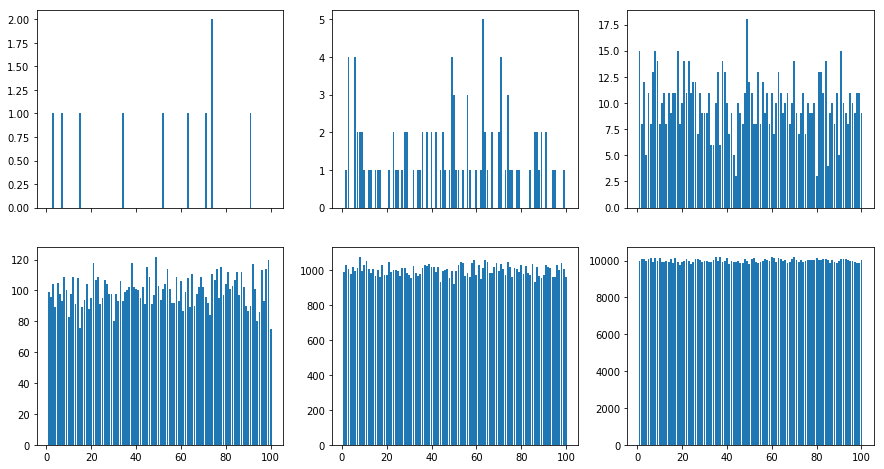

In [4]:
import math

counts = np.zeros(100)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.reshape(6)
# mangle subplots such that we can index them in a linear fashion rather than
# a 2d grid

for i in range(1, 1000001):
    counts[random.randint(0, 99)] += 1
    if i in [10, 100, 1000, 10000, 100000, 1000000]:
        axes[int(math.log10(i))-1].bar(np.arange(1, 101), counts)
plt.show()

What we can see from the above figures is that the initial number of counts looks *very* uneven. If we sample fewer than 100 draws from a distribution over 100 outcomes this is pretty much expected. But even for 1000 samples there is a significant variability between the draws. What we are really aiming for is a situation where the probability of drawing a number $x$ is given by $p(x)$.

## The categorical distribution

Quite obviously, drawing from a uniform distribution over a set of 100 outcomes is quite simple. But what if we have nonuniform probabilities? Let's start with a simple case, a biased coin which comes up heads with probability 0.35 and tails with probability 0.65. A simple way to sample from that is to generate a uniform random variable over $[0,1]$ and if the number is less than $0.35$, we output heads and otherwise we generate tails. Let's try this out.

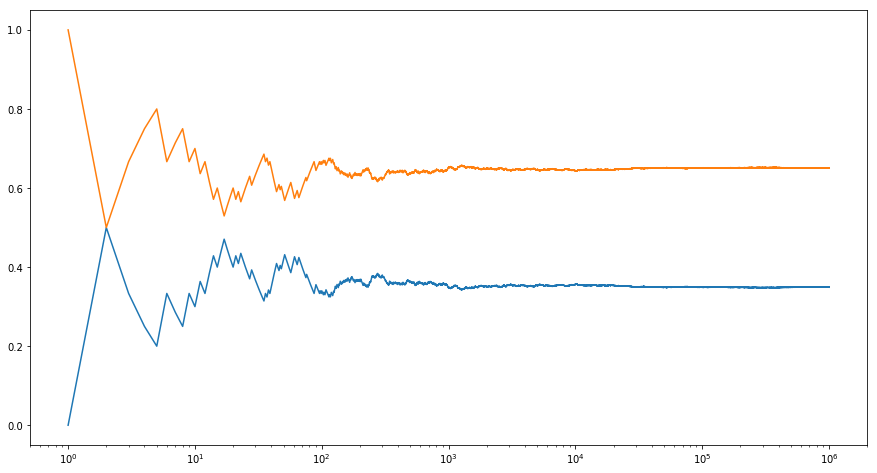

In [5]:
# number of samples
n = 1000000
y = np.random.uniform(0, 1, n)
x = np.arange(1, n+1)
# count number of occurrences and divide by the number of total draws
p0 = np.cumsum(y < 0.35) / x
p1 = np.cumsum(y >= 0.35) / x

plt.figure(figsize=(15, 8))
plt.semilogx(x, p0)
plt.semilogx(x, p1)
plt.show()

As we can see, on average this sampler will generate 35% zeros and 65% ones. Now what if we have more than two possible outcomes? We can simply generalize this idea as follows. Given any probability distribution, e.g.
$p = [0.1, 0.2, 0.05, 0.3, 0.25, 0.1]$ we can compute its cumulative distribution (python's ``cumsum`` will do this for you) $F = [0.1, 0.3, 0.35, 0.65, 0.9, 1]$. Once we have this we draw a random variable $x$ from the uniform distribution $U[0,1]$ and then find the interval where $F[i-1] \leq x < F[i]$. We then return $i$ as the sample. By construction, the chances of hitting interval $[F[i-1], F[i])$ has probability $p(i)$.

Note that there are many more efficient algorithms for sampling than the one above. For instance, binary search over $F$ will run in $O(\log n)$ time for $n$ random variables. There are even more clever algorithms, such as the [Alias Method](https://en.wikipedia.org/wiki/Alias_method) to sample in constant time, after $O(n)$ preprocessing.

## The Normal distribution

The Normal distribution (aka the Gaussian distribution) is given by $p(x) = \frac{1}{\sqrt{2 \pi}} \exp\left(-\frac{1}{2} x^2\right)$. Let's plot it to get a feel for it.

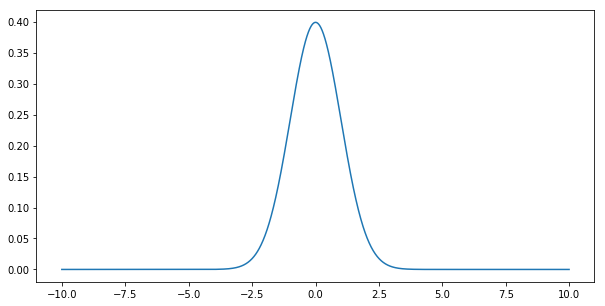

In [6]:
x = np.arange(-10, 10, 0.01)
p = (1/math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)
plt.figure(figsize=(10, 5))
plt.plot(x, p)
plt.show()

Sampling from this distribution is a lot less trivial. First off, the support is infinite, that is, for any $x$ the density $p(x)$ is positive. Secondly, the density is nonuniform. There are many tricks for sampling from it - the key idea in all algorithms is to stratify $p(x)$ in such a way as to map it to the uniform distribution $U[0,1]$. One way to do this is with the probability integral transform.

Denote by $F(x) = \int_{-\infty}^x p(z) dz$ the cumulative distribution function (CDF) of $p$. This is in a way the continuous version of the cumulative sum that we used previously. In the same way we can now define the inverse map $F^{-1}(\xi)$, where $\xi$ is drawn uniformly. Unlike previously where we needed to find the correct interval for the vector $F$ (i.e. for the piecewise constant function), we now invert the function $F(x)$.

In practice, this is slightly more tricky since inverting the CDF is hard in the case of a Gaussian. It turns out that the *twodimensional* integral is much easier to deal with, thus yielding two normal random variables than one, albeit at the price of two uniformly distributed ones. For now, suffice it to say that there are built-in algorithms to address this.

The normal distribution has yet another desirable property. In a way all distributions converge to it, if we only average over a sufficiently large number of draws from any other distribution. To understand this in a bit more detail, we need to introduce three important things: expected values, means and variances.

* The expected value $\mathbf{E}_{x \sim p(x)}[f(x)]$ of a function $f$ under a distribution $p$ is given by the integral $\int_x p(x) f(x) dx$. That is, we average over all possible outcomes, as given by $p$.
* A particularly important expected value is that for the function $f(x) = x$, i.e. $\mu := \mathbf{E}_{x \sim p(x)}[x]$. It provides us with some idea about the typical values of $x$.
* Another important quantity is the variance, i.e. the typical deviation from the mean
$\sigma^2 := \mathbf{E}_{x \sim p(x)}[(x-\mu)^2]$. Simple math shows (check it as an exercise) that
$\sigma^2 = \mathbf{E}_{x \sim p(x)}[x^2] - \mathbf{E}^2_{x \sim p(x)}[x]$.

The above allows us to change both mean and variance of random variables. Quite obviously for some random variable $x$ with mean $\mu$, the random variable $x + c$ has mean $\mu + c$. Moreover, $\gamma x$ has the variance $\gamma^2 \sigma^2$. Applying this to the normal distribution we see that one with mean $\mu$ and variance $\sigma^2$ has the form $p(x) = \frac{1}{\sqrt{2 \sigma^2 \pi}} \exp\left(-\frac{1}{2 \sigma^2} (x-\mu)^2\right)$. Note the scaling factor $\frac{1}{\sigma}$ - it arises from the fact that if we stretch the distribution by $\sigma$, we need to lower it by $\frac{1}{\sigma}$ to retain the same probability mass (i.e. the weight under the distribution always needs to integrate out to 1).

Now we are ready to state one of the most fundamental theorems in statistics, the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). It states that for sufficiently well-behaved random variables, in particular random variables with well-defined mean and variance, the sum tends toward a normal distribution. To get some idea, let's repeat the experiment described in the beginning, but now using random variables with integer values of $\{0, 1, 2\}$.

mean 0.9, variance 0.49


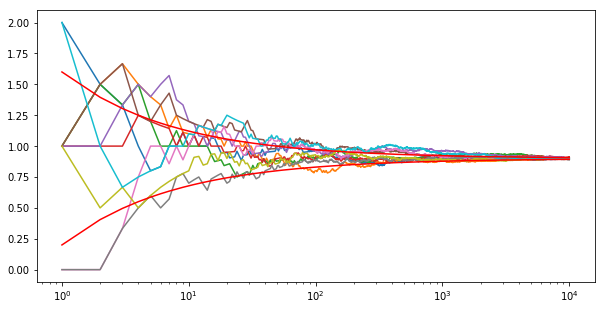

In [7]:
# generate 10 random sequences of 10,000 uniformly distributed random variables
tmp = np.random.uniform(size=(10000,10))
x = 1.0 * (tmp > 0.3) + 1.0 * (tmp > 0.8)
mean = 1 * 0.5 + 2 * 0.2
variance = 1 * 0.5 + 4 * 0.2 - mean**2
print('mean {}, variance {}'.format(mean, variance))
# cumulative sum and normalization
y = np.arange(1,10001).reshape(10000,1)
z = np.cumsum(x,axis=0) / y

plt.figure(figsize=(10,5))
for i in range(10):
    plt.semilogx(y,z[:,i])

plt.semilogx(y,(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.semilogx(y,-(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.show()

This looks very similar to the initial example, at least in the limit of averages of large numbers of variables. This is confirmed by theory. Denote by mean and variance of a random variable the quantities

$$\mu[p] := \mathbf{E}_{x \sim p(x)}[x] \text{ and } \sigma^2[p] := \mathbf{E}_{x \sim p(x)}[(x - \mu[p])^2]$$

Then we have that $\lim_{n\to \infty} \frac{1}{\sqrt{n}} \sum_{i=1}^n \frac{x_i - \mu}{\sigma} \to \mathcal{N}(0, 1)$. In other words, regardless of what we started out with, we will always converge to a Gaussian. This is one of the reasons why Gaussians are so popular in statistics.


## More distributions

Many more useful distributions exist. We recommend consulting a statistics book or looking some of them up on Wikipedia for further detail.

* **Binomial Distribution** It is used to describe the distribution over multiple draws from the same distribution, e.g. the number of heads when tossing a biased coin (i.e. a coin with probability $\pi \in [0, 1]$ of returning heads) 10 times. The binomial probability is given by $p(x) = {n \choose x} \pi^x (1-\pi)^{n-x}$.
* **Multinomial Distribution** Obviously we can have more than two outcomes, e.g. when rolling a dice multiple times. In this case the distribution is given by $p(x) = \frac{n!}{\prod_{i=1}^k x_i!} \prod_{i=1}^k \pi_i^{x_i}$.
* **Poisson Distribution** It is used to model the occurrence of point events that happen with a given rate, e.g. the number of raindrops arriving within a given amount of time in an area (weird fact - the number of Prussian soldiers being killed by horses kicking them followed that distribution). Given a rate $\lambda$, the number of occurrences is given by $p(x) = \frac{1}{x!} \lambda^x e^{-\lambda}$.
* **Beta, Dirichlet, Gamma, and Wishart Distributions** They are what statisticians call *conjugate* to the Binomial, Multinomial, Poisson and Gaussian respectively. Without going into detail, these distributions are often used as priors for coefficients of the latter set of distributions, e.g. a Beta distribution as a prior for modeling the probability for binomial outcomes.


## Discuss on our Forum

<div id="discuss" topic_id="2321"></div>